# Titanic Dataset

In [265]:
#import data
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
train = pd.read_csv('train_titanic.csv')


In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [168]:
train.Sex.value_counts()

Sex
male      577
female    314
Name: count, dtype: int64

In [169]:
train.Survived.value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

I build a model on train data, then apply it to test data and turn results into a csv with passenger ID and Survived column.  
For this model I will build a binary classifier and use classificaion report to measure success.

In [6]:
#inspect nulls
train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [7]:
train.shape

(891, 12)

Most of cabin are nulls

In [8]:
train.Cabin.value_counts()

Cabin
B96 B98        4
G6             4
C23 C25 C27    4
C22 C26        3
F33            3
              ..
E34            1
C7             1
C54            1
E36            1
C148           1
Name: count, Length: 147, dtype: int64

Since there are 147 different cabins out of 204 entries and 687 null values, I will drop this column. I will also drop name column as I have passenger ID. For age I will use simple imputer to replace NAs with median. For embarked I will use most frequent.

In [12]:
train.Ticket.value_counts()

Ticket
347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: count, Length: 681, dtype: int64

Ticket number has 681 different types out of 891. Since I have Port of Embarkation and pcalss, ticket is not useful and will be dropped.

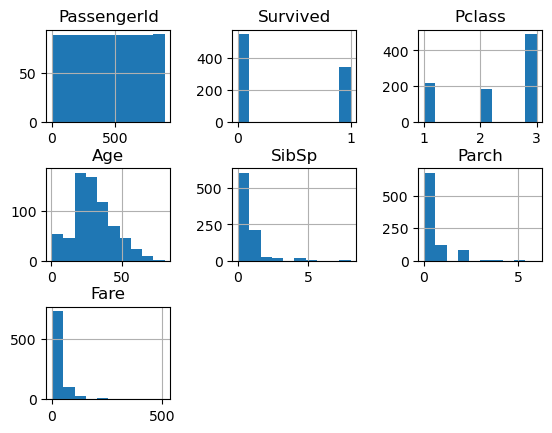

In [190]:
import matplotlib.pyplot as plt
#explore distribution of numerical categories
train.hist(bins=10)
plt.subplots_adjust(wspace=0.5, hspace=0.5);

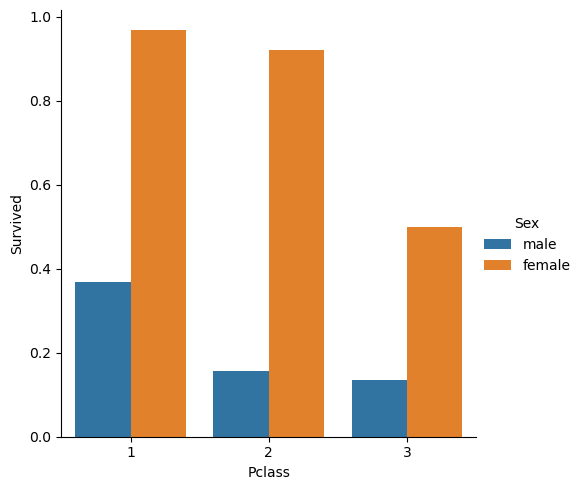

In [8]:
import seaborn as sns
sns.catplot(data = train, kind='bar',x = 'Pclass', y='Survived', hue='Sex', errorbar=None);

It seems females of Pclass 1 and 2 have highest survival rate.

In [55]:
train.Pclass.value_counts()

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

In [56]:
train12 = train[~(train.Pclass == 3)]

For last 4, I will apply log transformation to fix right skew. Then standardise all data.

For sex and embarked they are non ordinal so I will use one hot encoder to split into numerical data.

The pipeline:  
1. Remove Cabin, Ticket, Name
2. Use simple imputer to fill in null values
3. Use log to transform right skew data
4. Use standard scaler to standardize data
5. Use one hot encoder to turn non-ordinal categories into numeric categories

In [267]:
from sklearn.model_selection import train_test_split
#create function to split data into X and y and remove irrelevant rows
y = train.Survived
X = train.drop('Survived',axis=1)

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42, stratify = X.Sex)



In [268]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector

# Create function to split data into X and y and remove irrelevant rows
def clean(data):

    data['Title'] = data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)  # Extract Title from Name
    data['Title'] = data['Title'].replace(['Lady', 'Countess', 'Capt', 'Col', 'Don', 'Dr', 'Major', 
                                           'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Unique') 
    data['Title'] = data['Title'].replace('Mlle', 'Miss').replace('Mme', 'Mrs').replace('Ms', 'Mr')
    data['Fare'] = pd.cut(data['Fare'], bins=[0,50,100,150,200,np.inf], labels=[1,2,3,4,5])
    data['Family'] = data['SibSp']+data['Parch']
    data.Age = data.Age.fillna(data.Age.median())
    data.Age= pd.cut(data['Age'], bins =[0,5,18,30,42,50,np.inf],labels=[1,2,3,4,5,6])
    data.drop([ 'Ticket','Cabin', 'Name', 'PassengerId'], axis=1, inplace=True)  
    return data

# Create log pipeline
log_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    FunctionTransformer(np.log1p, validate=False,feature_names_out = 'one-to-one'),  
    StandardScaler()
)

# Create category pipeline
cat_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore')
)

# Create default pipeline
def_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

# Preprocess pipeline
preprocess = ColumnTransformer(
    transformers=[
        ('log', log_pipeline, [ 'SibSp', 'Parch','Family']),
        ('cat', cat_pipeline, make_column_selector(dtype_include=object))
    ],
    remainder=def_pipeline
)


In [269]:
#apply clean to train and then preprocess to get final X

Xtrain = preprocess.fit_transform(clean(Xtrain))

In [270]:
Xtest = preprocess.fit_transform(clean(Xtest))

In [271]:
preprocess.get_feature_names_out()

array(['log__SibSp', 'log__Parch', 'log__Family', 'cat__Sex_female',
       'cat__Sex_male', 'cat__Embarked_C', 'cat__Embarked_Q',
       'cat__Embarked_S', 'cat__Title_Master', 'cat__Title_Miss',
       'cat__Title_Mr', 'cat__Title_Mrs', 'cat__Title_Unique',
       'remainder__Pclass', 'remainder__Age', 'remainder__Fare'],
      dtype=object)

In [272]:
Xtest.shape

(179, 16)

## Build Models

### Model 1

In [273]:
#for Model 1 I will build a logistic model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

lr = LogisticRegression(random_state=42)
lr.fit(Xtrain, ytrain)

pred = lr.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85       114
           1       0.74      0.77      0.75        65

    accuracy                           0.82       179
   macro avg       0.80      0.81      0.80       179
weighted avg       0.82      0.82      0.82       179

0.8156424581005587


### Model 2

In [274]:
#for model 2 I will use Random Forest
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(Xtrain,ytrain)

pred = rf.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       114
           1       0.80      0.75      0.78        65

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

0.8435754189944135


### Model 3

In [275]:
#for model 3 I will use MLP

from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=42)
mlp.fit(Xtrain,ytrain)

pred = mlp.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       114
           1       0.80      0.74      0.77        65

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179

0.8379888268156425


### Model 4

In [276]:
#for model 4 I will use svm classifier
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(Xtrain,ytrain)
       
pred = svm.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.86      0.87      0.86       114
           1       0.77      0.75      0.76        65

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179

0.8268156424581006


### Model 5

In [277]:
#For model 5 i will use decision tree classifier
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(random_state=42)
dt.fit(Xtrain,ytrain)

pred = dt.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))


              precision    recall  f1-score   support

           0       0.85      0.93      0.89       114
           1       0.85      0.71      0.77        65

    accuracy                           0.85       179
   macro avg       0.85      0.82      0.83       179
weighted avg       0.85      0.85      0.85       179

0.8491620111731844


### Model 6

In [278]:
#for model 6 I will use Grad Boost
from sklearn.ensemble import GradientBoostingClassifier

gbc = GradientBoostingClassifier()
gbc.fit(Xtrain, ytrain)

pred = gbc.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.88      0.89      0.89       114
           1       0.81      0.78      0.80        65

    accuracy                           0.85       179
   macro avg       0.84      0.84      0.84       179
weighted avg       0.85      0.85      0.85       179

0.8547486033519553


### Model 7 

In [282]:
#use a voting classifier to combine best models
from sklearn.ensemble import VotingClassifier

estimators = [
    ('mlp',mlp),
    ('gbc',gbc),
    ('rf',rf)
]

vc = VotingClassifier(estimators = estimators, voting = 'soft')
vc.fit(Xtrain,ytrain)

pred = vc.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       114
           1       0.83      0.77      0.80        65

    accuracy                           0.86       179
   macro avg       0.85      0.84      0.85       179
weighted avg       0.86      0.86      0.86       179

0.8603351955307262


### Model 8

In [281]:
#use a stacking classifier to combine best models
from sklearn.ensemble import StackingClassifier

estimators = [
    ('mlp',mlp),
    ('gbc',gbc),
    ('rf',rf)
]

sc = StackingClassifier(estimators = estimators, final_estimator = rf)
sc.fit(Xtrain,ytrain)

pred = sc.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       114
           1       0.82      0.72      0.77        65

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179

0.8435754189944135


## Hyperparameter tuning

In [284]:
#use random search for gbc
from sklearn.model_selection import RandomizedSearchCV

distributions = dict(
    loss=['log_loss','exponential'],
    learning_rate=[0.1,0.5,1],
    n_estimators=[50,100,200],
    criterion=['friedman_mse','squared_error'],
    max_features=['sqrt','log2',None]
)

clf3 = RandomizedSearchCV(gbc, distributions, scoring='accuracy', cv=3, random_state =5)
search3 = clf3.fit(Xtrain,ytrain)
search3.best_params_
pred = search3.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       114
           1       0.76      0.77      0.76        65

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179

0.8268156424581006


In [285]:
#use random search for mlp
from sklearn.model_selection import RandomizedSearchCV

distributions = dict(
    hidden_layer_sizes=[10,50,100,200],
    activation=['identity','logistic','tanh','relu'],
    solver=['lbfgs','sgd','adam'],
    alpha=[0.00001,0.0001,0.001,0.01]
)

clf2 = RandomizedSearchCV(mlp, distributions, scoring='accuracy', cv=3, random_state=5)
search2 = clf2.fit(Xtrain,ytrain)
search2.best_params_
pred = search2.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.86      0.89      0.88       114
           1       0.80      0.74      0.77        65

    accuracy                           0.84       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.84      0.84      0.84       179

0.8379888268156425


In [286]:
#use random search for rf
from sklearn.model_selection import RandomizedSearchCV

distributions = dict(
    criterion = ['gini','entropy','log_loss'],
    max_features=['sqrt','log2',None],
    max_depth=[2,4,6,8,10,12,14,16],
    min_samples_split = [2,3,4,5,6,8,10,12]
)

clf3 = RandomizedSearchCV(rf, distributions, scoring='accuracy', cv=3, random_state =5)
search3 = clf3.fit(Xtrain,ytrain)
search3.best_params_
pred = search3.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.86       114
           1       0.76      0.77      0.76        65

    accuracy                           0.83       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.83      0.83      0.83       179

0.8268156424581006


In [314]:
#use a voting classifier to combine best models
from sklearn.ensemble import VotingClassifier

estimators = [
    ('gbc',clf),
    ('mlp',clf2),
    ('rf',clf3)
]

vc = VotingClassifier(estimators = estimators, voting = 'soft')
vc.fit(Xtrain,ytrain)

pred = vc.predict(Xtest)
print(classification_report(ytest,pred))
print(accuracy_score(ytest,pred))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88       114
           1       0.79      0.77      0.78        65

    accuracy                           0.84       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.84      0.84      0.84       179

0.8435754189944135


## Estimate survival on test set

In [305]:
test = pd.read_csv('test_titanic.csv')
test2 = test.copy()

In [257]:
test.Sex.value_counts()

Sex
male      266
female    152
Name: count, dtype: int64

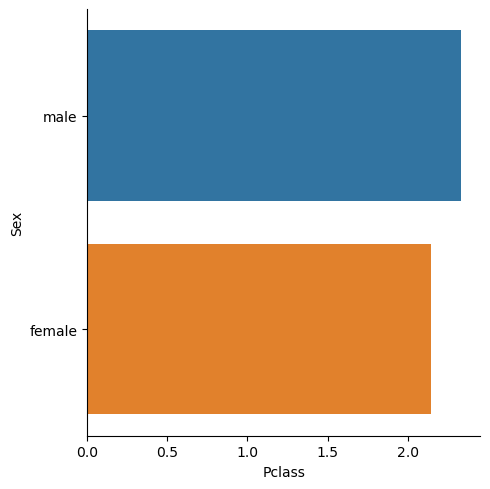

In [192]:
import seaborn as sns
sns.catplot(data = test, kind='bar',x = 'Pclass', y='Sex', errorbar=None);

In [306]:
sample = preprocess.fit_transform(clean(test2))

In [307]:
sample

array([[-0.6336812 , -0.49769194, -0.72074147, ...,  0.87348191,
         0.55151284,  0.08502303],
       [ 1.03851197, -0.49769194,  0.49691228, ...,  0.87348191,
         1.45556134,  0.08502303],
       [-0.6336812 , -0.49769194, -0.72074147, ..., -0.31581919,
         2.35960984,  0.08502303],
       ...,
       [-0.6336812 , -0.49769194, -0.72074147, ...,  0.87348191,
         0.55151284,  0.08502303],
       [-0.6336812 , -0.49769194, -0.72074147, ...,  0.87348191,
        -0.35253566,  0.08502303],
       [ 1.03851197,  1.14058982,  1.20919407, ...,  0.87348191,
        -0.35253566,  0.08502303]])

In [308]:
sample.shape

(418, 16)

In [309]:
predictions = vc.predict(sample)
predictions

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [310]:
pd.DataFrame(predictions,columns=['Survived'])

,Survived
0,0
1,0
2,0
3,0
4,0
...,...
413,0
414,1
415,0
416,0


In [311]:
test.index

RangeIndex(start=0, stop=418, step=1)

In [312]:
#create df of predictions
df = pd.DataFrame(predictions,test.PassengerId)
df.columns = ['Survived']
df

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
...,...
1305,0
1306,1
1307,0


In [313]:
df.to_csv('titanic_survivors.csv')

In [380]:
data = clean(train)

In [381]:
data

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title,Family
0,0,3,male,22.0,1,0,1,S,Mr,1
1,1,1,female,38.0,1,0,2,C,Mrs,1
2,1,3,female,26.0,0,0,1,S,Miss,0
3,1,1,female,35.0,1,0,2,S,Mrs,1
4,0,3,male,35.0,0,0,1,S,Mr,0
...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,1,S,Unique,0
887,1,1,female,19.0,0,0,1,S,Miss,0
888,0,3,female,NaN,1,2,1,S,Miss,3
889,1,1,male,26.0,0,0,1,C,Mr,0


In [388]:
data.groupby(['Title','Pclass'])['Age'].mean().reset_index()

,Title,Pclass,Age
0,Master,1,5.306667
1,Master,2,2.258889
2,Master,3,5.350833
3,Miss,1,29.744681
4,Miss,2,22.390625
5,Miss,3,16.123188
6,Mr,1,41.580460
7,Mr,2,32.710843
8,Mr,3,28.724891
9,Mrs,1,40.400000
